# Estimation of the Mean Function of Functional Data via Deep Neural Networks

In [92]:
# nibabel documentation: https://nipy.org/nibabel/gettingstarted.html
# https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/#:~:text=The%20number%20of%20epochs%20is%20a%20hyperparameter%20that%20defines%20the,update%20the%20internal%20model%20parameters.

In [1]:
import pandas as pd
import numpy as np
from itertools import product
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Flatten, Dense, Dropout)
import nibabel as nib
from nibabel.testing import data_path

import pydot_ng
import pydot
import pydotplus
import graphviz
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', None)

In [2]:
images = nib.load('data.nii')

In [3]:
data = images.get_fdata().T #transpose the original data - it should fit the format 95*79

In [4]:
data[0].shape

(95, 79)

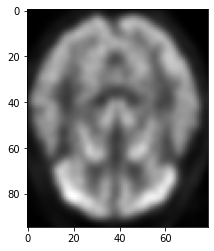

In [5]:
plt.imshow((data[20]), cmap='gray')
plt.show()

# Data definition
- There are 69 images slices contained in a 3D data cube.
- We use one slice from a given cube.
- When combining with other slices from other images we need to make sure that we select the slice from the same position inside the cube.
- Each image slice is a 95x79 matrix.
- Each row of the matrix is the output vector which needs to be predicted. These are the individual pixels in the image.
- To predict the output we need to generate the features which are the coordinates of each pixel in the output vector.
- The coordinates need to be normalized to 1 so for each coordinate needs to be divided by the $L_0$ norm of the vector.
    - Example: for the first pixel the coordinates will be $(\frac{1}{95},\frac{1}{79})$ and for the last pixel the coordinates will be $(\frac{1}{95}, \frac{79}{79})$
-------------------------------------------------------

# Model input and output
## Input: a set of coordinates e.g. $(\frac{1}{95},\frac{1}{79})$

### X:
- Get all the first coordinates as first column of the input matrix
- Get all the second coordinates as the second column of the input matrix
----------------------------------------------------------
## Output: predicted value for the pixel at that coordinate.

### Y:
- Take the matrix that contains the actual pixels for each image (this is the desired output) and ravel the array to get it into a single array of 95*79 elements each corresponding to the pixel value that needs to be predicted.
    - example: for an image with dimensions 95x79 - the total number of coordinate sets should be 95*79
    - the number of coordinates should be exactly the same as the number of pixels in the image - this will give a 1:1 correspondence between coordinates and pixels
    - even though as the image changes the pixels in the image change - the coordinates will remain the same for each pixel.

In [6]:
# i, j = np.indices(dimensions=(95,79), sparse=True)
# del i, j

In [7]:
#this gives you coordinates as two separate arrays 1 for each coordinate. Since the original matrix to be predicted is 95 rows, we get two arrays of length 95 - one for each coordinate
# np.indices(dimensions=(95,79)).shape 

In [13]:
Y = data[20].ravel() #flatten the matrix of pixels into a single array
Y = pd.DataFrame(Y, columns=['pixel_value']) #for the first image

In [14]:
#get the number of rows and columns for the matrix of pixels per image
rows = data[20].shape[0] #number of rows
cols = data[20].shape[1] #number of columns

#generate coordinates
row_indices = list()
column_indices = list()

row_coordinates =  (np.indices(dimensions=(rows, cols))[0]+1)*(1/rows) #add 1 to avoid start from 0 - multiply by 1/cols to notmalize
column_coordinates =  (np.indices(dimensions=(rows, cols))[1]+1)*(1/cols) #add 1 to avoid start from 0 - multiply by 1/cols to notmalize

for row in row_coordinates:
    for row_index in row:
        row_indices.append(row_index)

for row in column_coordinates:
    for column_index in row:
        column_indices.append(column_index)

In [15]:
X = pd.DataFrame(columns=['X_coordinate', 'Y_coordinate'])
X['X_coordinate'] = np.array(row_indices)
X['Y_coordinate'] = np.array(column_indices)

In [16]:
Y.shape

(7505, 1)

In [17]:
X.shape

(7505, 2)

- Should coordinates and pixels values for all images be stacked and one combined dataset be created?

## Models

In [13]:
# del model

In [91]:
class Callback(tf.keras.callbacks.Callback):
    epoch_controller = 10

    def on_epoch_end(self, epoch, logs=None):
        self.epoch = epoch
        if (self.epoch%self.epoch_controller==0):
            print('Epoch: ' + str(self.epoch) + ' loss: ' + str(logs['loss']))
        
def model(X_train, Y_train, epochs=500, dropout_rate=0.25, loss='huber', verbose=0):
    """
    create and return the desired model
    """
    model = keras.models.Sequential([
        Flatten(input_shape=X.shape[1:]),
        Dense(1000, activation='relu'),
        Dense(1000, activation='relu'),
        Dropout(dropout_rate),
        Dense(1)
    ])
            
    #define loss to minimize
    if loss=='huber':
        loss_to_minimize = tf.keras.losses.Huber() 
    elif loss=='mse':
        loss=tf.keras.losses.MeanSquaredError
    
    #compile the model
    model.compile(loss=loss_to_minimize, 
                  optimizer="sgd")
    
    #model fit
    model_history = model.fit(X_train, Y_train, batch_size=10, epochs=epochs,  callbacks=[Callback()], verbose=verbose)
    
    return model_history, model

In [ ]:
model_history, dnn_model = model(X, Y, epochs=200, dropout_rate=0.25, loss='huber', verbose=0)

Epoch: 0 loss: 0.1137842908501625
Epoch: 10 loss: 0.06582941859960556
Epoch: 20 loss: 0.0541386604309082
Epoch: 30 loss: 0.04938621073961258
Epoch: 40 loss: 0.045956533402204514
Epoch: 50 loss: 0.04336150735616684
Epoch: 60 loss: 0.04122715815901756
Epoch: 70 loss: 0.038841720670461655
Epoch: 80 loss: 0.037378594279289246
Epoch: 90 loss: 0.03559776395559311
Epoch: 100 loss: 0.03423364832997322
Epoch: 110 loss: 0.032784588634967804
Epoch: 120 loss: 0.0320206880569458
Epoch: 130 loss: 0.031042350456118584
Epoch: 140 loss: 0.030035411939024925
Epoch: 150 loss: 0.029231131076812744
Epoch: 160 loss: 0.02875542640686035
Epoch: 170 loss: 0.028072809800505638
Epoch: 180 loss: 0.027443263679742813
Epoch: 190 loss: 0.026814473792910576


In [78]:
print(dnn_model.summary())

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_20 (Flatten)        (None, 2)                 0         
                                                                 
 dense_60 (Dense)            (None, 1000)              3000      
                                                                 
 dense_61 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_20 (Dropout)        (None, 1000)              0         
                                                                 
 dense_62 (Dense)            (None, 1)                 1001      
                                                                 
Total params: 1,005,001
Trainable params: 1,005,001
Non-trainable params: 0
_________________________________________________________________
None


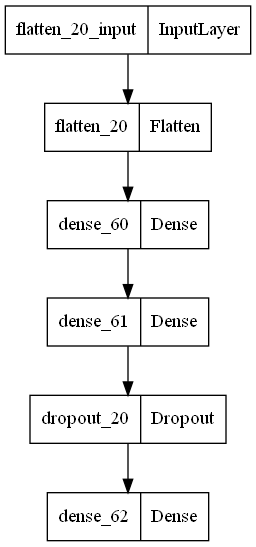

In [79]:
keras.utils.plot_model(dnn_model)

In [83]:
y_pred = dnn_model.predict(X)

In [84]:
data[20].shape

(95, 79)

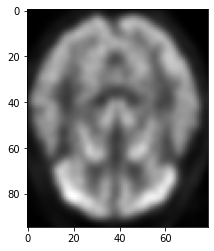

In [85]:
plt.imshow((data[20]), cmap='gray')

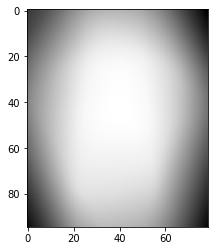

In [86]:
plt.imshow(np.reshape(y_pred, (95, 79)), cmap='gray')